## Churn Prediction

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Load the dataset
file_path = 'Resources/Final customer dataset.csv'  
customer_df = pd.read_csv(file_path)

In [23]:
# Display the first few rows of the DataFrame
customer_df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,4625100001,2020-09-08 9:38,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,4625100001,2022-03-05 12:56,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,4625100001,2022-05-23 18:18,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,4625100001,2020-11-12 13:13,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,1359300001,2020-11-27 17:55,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


In [25]:
# Drop irrelevant columns
customer_df.drop(columns=['Customer Name', 'Purchase Date', 'Customer ID', 'Age'], inplace=True, errors='ignore')

In [27]:
# Handle missing values
customer_df['Returns'].fillna(0, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_18100\2158212650.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_df['Returns'].fillna(0, inplace=True)


In [26]:
# Define features (X) and target (y)
X = customer_df.drop(columns=['Churn'])
y = customer_df['Churn']

In [28]:
# Identify numeric and categorical features
numeric_features = ['Product Price', 'Total Purchase Amount', 'Customer Age', 'Quantity']
categorical_features = ['Product Category', 'Payment Method', 'Gender']

In [29]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

In [30]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Build the pipeline with a RandomForestClassifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [33]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Product Price',
                                                   'Total Purchase Amount',
                                                   'Customer Age',
                                                   'Quantity']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Product Category',
                                                   'Payment Method',
                                                   'Gender'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [34]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

In [35]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nROC-AUC Score:", roc_auc)

Model Accuracy: 0.78855

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88     79969
           1       0.20      0.02      0.03     20031

    accuracy                           0.79    100000
   macro avg       0.50      0.50      0.46    100000
weighted avg       0.68      0.79      0.71    100000


ROC-AUC Score: 0.5051050038117617


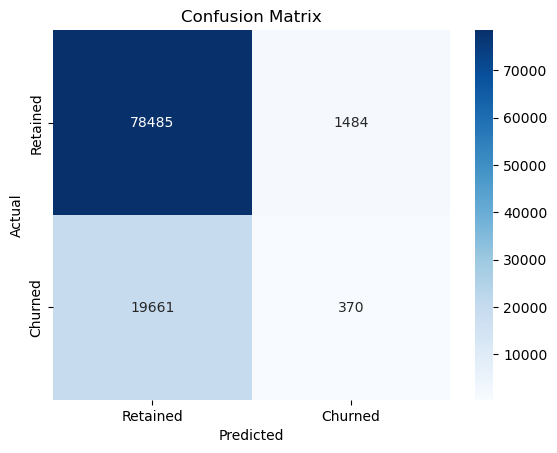

In [39]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig('output/confusion_matrix_churn_pred.png')
plt.show()

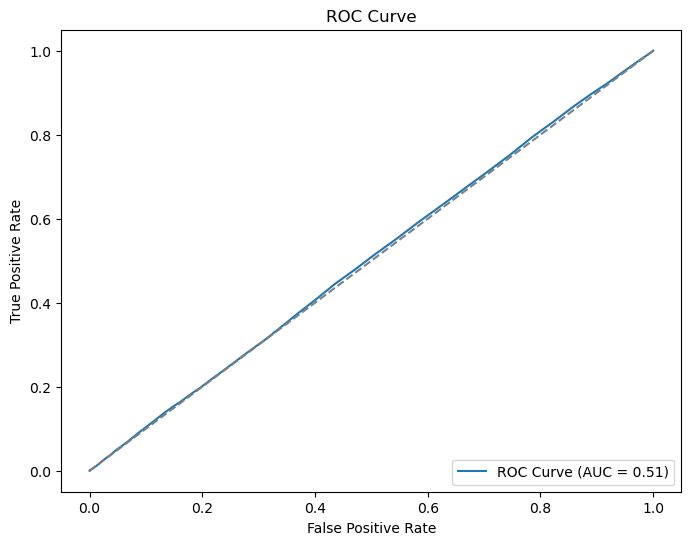

In [43]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

plt.savefig('output/ROC_curve(churn).png')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_18100\322051059.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')


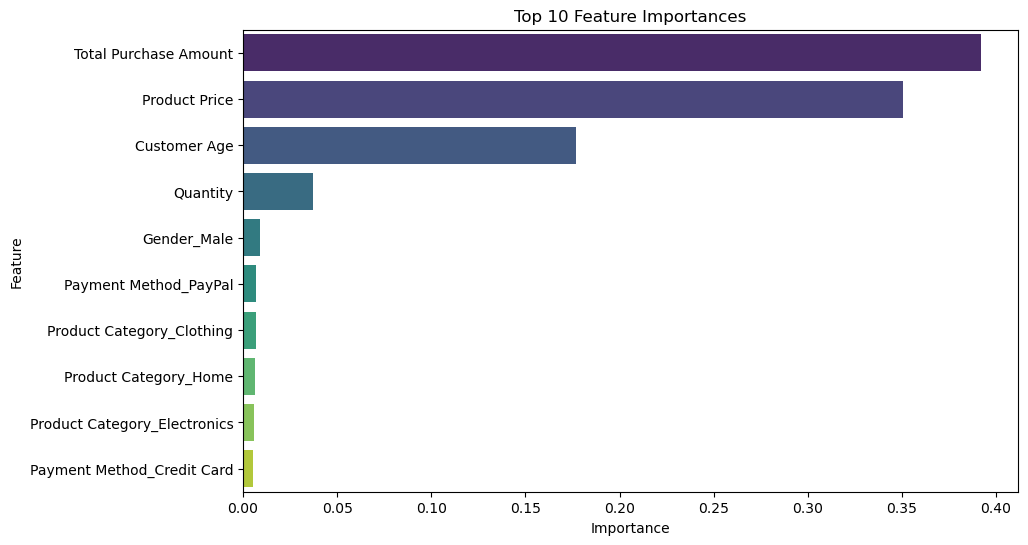

In [44]:
# Feature Importance
if isinstance(model.named_steps['classifier'], RandomForestClassifier):
    feature_names = numeric_features + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
    importances = model.named_steps['classifier'].feature_importances_
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')
    plt.title("Top 10 Feature Importances")

    plt.savefig('output/top10_features(churn).png')
    plt.show()